### Neural network classification with pytorch

## Make classification data and get it ready

In [1]:
import torch
import sklearn 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.datasets import make_circles

In [2]:
#Make 1000 samples
n_samples=1000
#Create circles
X,y=make_circles(n_samples,
                noise=0.03,
                 random_state=42)
y.shape

(1000,)

In [3]:
circles=pd.DataFrame({'X1':X[:,0],
             'X2':X[:,1],
             'label':y
             })


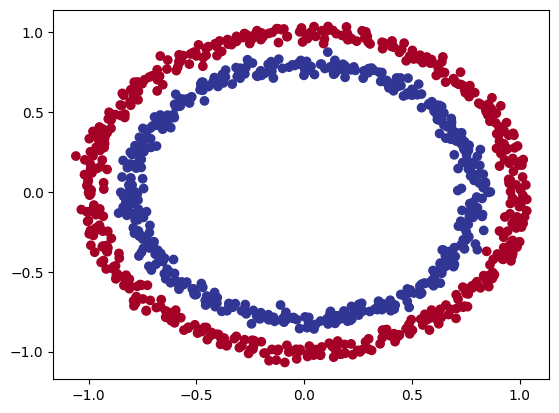

In [4]:
plt.scatter(x=X[:,0],
        y=X[:,1],
        c=y,
        cmap=plt.cm.RdYlBu)


## Cheking input and output shapes

In [5]:
print(f'Value of samples of x :{X[0]} and samples of y :{y[0]}')
print(f'shape of samples of x :{X[0].shape} and shape of y :{y[0].shape}')

Value of samples of x :[0.75424625 0.23148074] and samples of y :1
shape of samples of x :(2,) and shape of y :()


In [6]:
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building a model
Let's build a model to classify our blue and red dots

To do we want to :
1. Setup device agonistic code so our code run in accelerator (GPU) if there is one
2. Contruct a model(by subclassing `nn.Module`)
3. define a loss function and optimizer
4. Create a training and testing loop

In [8]:
from torch import nn
# make device agnostic code 
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Let's creat a model that:

1. sub classes `nn.Module`
2. Create 2 `nn.Linear()` layer are capable handling the shape of our data
3. Defines a `forward()` method
4. installation an instance of our model and send it to target device

In [9]:
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=(correct/len(y_pred))*100
    return acc
    

In [10]:
X.shape

torch.Size([1000, 2])

In [11]:
torch.manual_seed(42)
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2,out_features=5)
        self.layer_2=nn.Linear(in_features=5,out_features=1)
    def forward(self,x):
        return self.layer_2(self.layer_1(x))#x ->layer1 -> layer2 -> output
        
model_0=CircleModelV0().to(device)
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('layer_2.bias', tensor([-0.2060]))])

In [14]:
#let's replicate the model above using nn.Sequential()
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
)

In [13]:
loss_fn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [14]:
torch.manual_seed(42)
epochs=1000
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    
    y_logits=model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss=loss_fn(y_logits,y_train)## Using nn.BCEWithLogitsLoss works with raw logits

    acc=accuracy_fn(y_pred=y_pred,y_true=y_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_0.eval()
    with torch.inference_mode():
         if epoch%30==0:
             test_logits = model_0(X_test).squeeze() 
             test_pred = torch.round(torch.sigmoid(test_logits))
      
             test_loss = loss_fn(test_logits,y_test)
             test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)
             
             print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:0.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
            

Epoch: 0 | Loss: 0.69569, Accuracy: 50.00% | Test loss: 0.69721, Test acc: 50.00%
Epoch: 30 | Loss: 0.69321, Accuracy: 49.00% | Test loss: 0.69577, Test acc: 47.50%
Epoch: 60 | Loss: 0.69306, Accuracy: 50.50% | Test loss: 0.69564, Test acc: 46.50%
Epoch: 90 | Loss: 0.69303, Accuracy: 50.38% | Test loss: 0.69547, Test acc: 46.50%
Epoch: 120 | Loss: 0.69301, Accuracy: 50.62% | Test loss: 0.69532, Test acc: 45.50%
Epoch: 150 | Loss: 0.69300, Accuracy: 50.75% | Test loss: 0.69519, Test acc: 45.50%
Epoch: 180 | Loss: 0.69299, Accuracy: 50.88% | Test loss: 0.69509, Test acc: 46.50%
Epoch: 210 | Loss: 0.69299, Accuracy: 51.50% | Test loss: 0.69501, Test acc: 46.50%
Epoch: 240 | Loss: 0.69299, Accuracy: 51.25% | Test loss: 0.69494, Test acc: 45.50%
Epoch: 270 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69489, Test acc: 45.50%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69485, Test acc: 45.50%
Epoch: 330 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69481, Test acc: 45.5

In [15]:
#Logits -->  pred_probs  -->  pred_label
y_pred_label=torch.round(torch.sigmoid(model_0(X_test).to(device))[:5])
y_pred_label

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.]], grad_fn=<RoundBackward0>)

## Make a prediction and evaluate the model 
From the metrics it looks like our model isn't learning anything....

So to inspect it lets make some prediction and make them visualize 

In [16]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print("Helper file is exist")
else:
    print("Helper isn't exist downloading....")
    req=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open('helper_functions.py',"wb") as f:
        f.write(req.content)
from helper_functions import plot_predictions,plot_decision_boundary        

Helper file is exist


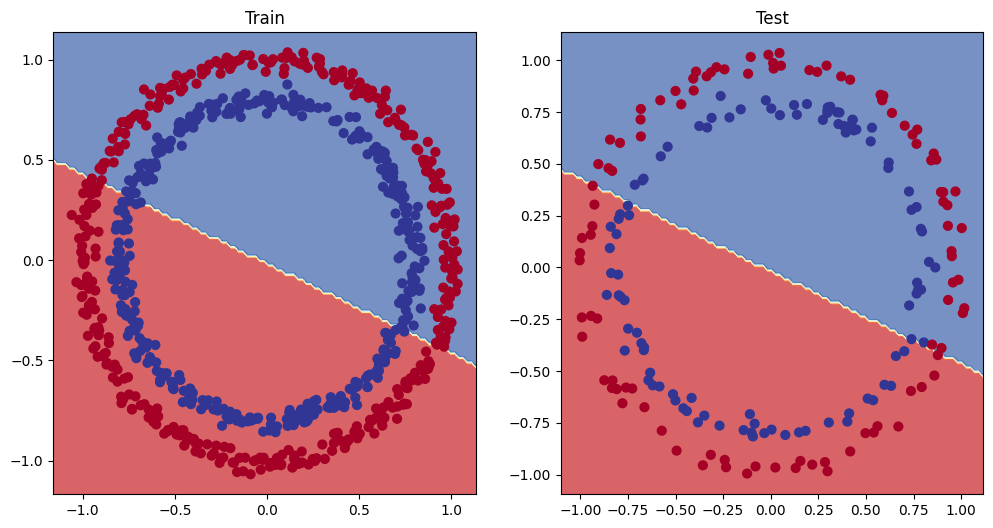

In [17]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

In [18]:
##Add more hidden layer 2->3
#Add more hidden units 5->10
#Add epochs
torch.manual_seed(42)
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2,out_features=128)
        self.layer_2=nn.ReLU()
        self.layer_3=nn.Linear(in_features=128,out_features=1)
    def forward(self,x):
        return self.layer_3(self.layer_2(self.layer_1(x))) #x ->layer1 -> layer2 -> output
        
model_0=CircleModelV0().to(device)
#model_0.state_dict()

In [19]:
y_logits=model_0(X_train).squeeze()
y_predi=torch.round(torch.sigmoid(y_logits))
accuracy_fn(y_pred=y_predi,y_true=y_train)

49.5

## 1.Creating a toy multi_class dataset 

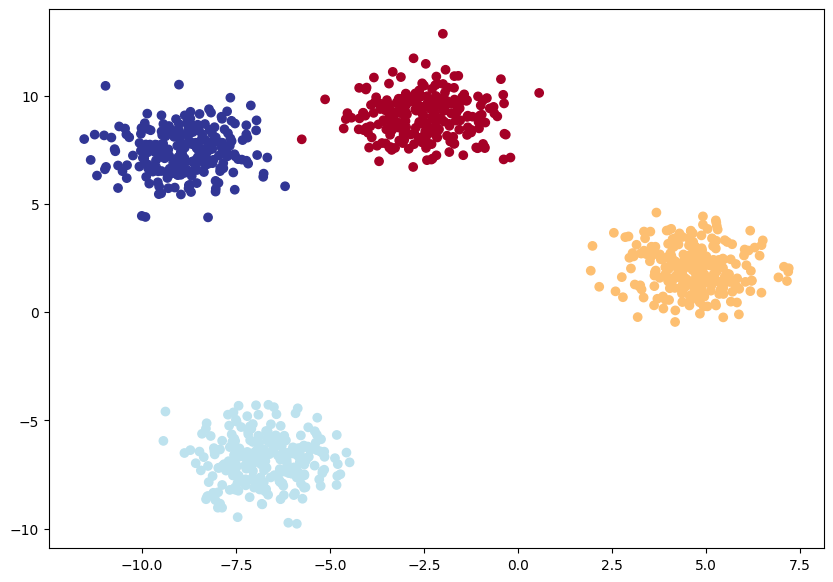

In [147]:
#Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#Set the hyper parameters for data creation
NUM_FEATURES=2
NUM_CLASSES=4
RANDOM_SEED=42

#1. Creating muli_class data
X_blob,y_blob=make_blobs(n_samples=1000,
                        n_features=NUM_FEATURES,
                        centers=NUM_CLASSES,
                        cluster_std=1,# give the clusters a little shake up
                        random_state=RANDOM_SEED)

#2. turn data into tensors 
X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

#3. split into train test 
X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

#plot data visualize visualize visualize
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

## 2.Building a multi-class classification model in Pytorch

In [21]:
# Create device agnostic code
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [178]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=8):
        super().__init__()
        self.linear_layer_stack=nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
           # nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )
    def forward(self,x):
        return self.linear_layer_stack(x)
model_1=BlobModel(input_features=2,output_features=4,hidden_units=5)    


In [179]:
torch.unique(y_blob_test)#output feature NUM

tensor([0, 1, 2, 3])

In [180]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [185]:
#train model_1
torch.manual_seed(RANDOM_SEED)

epochs=1000

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):

    model_1.train()
    
    y_logits=model_1(X_blob_train)
    y_pred=(y_logits).argmax(dim=1)
    
    acc_train = accuracy_fn(y_true=y_blob_train,y_pred=y_pred)
    
    loss=loss_fn(y_logits,y_blob_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if epoch%30==0:
        
        y_logits_test=model_1(X_blob_test)
        y_pred_test=(y_logits_test).argmax(dim=1)
   
        loss_test=loss_fn(y_logits_test,y_blob_test)
        
        acc_test = accuracy_fn(y_true=y_blob_test,y_pred=y_pred_test)
        print(f"epoch:{epoch}||acc_train: {acc_train:.5f}||loss_train: {loss:.5f}||acc_test: {acc_test}||loss_test: {loss_test:.5f}")

epoch:0||acc_train: 99.87500||loss_train: 0.00186||acc_test: 100.0||loss_test: 0.00082
epoch:30||acc_train: 99.87500||loss_train: 0.00184||acc_test: 100.0||loss_test: 0.00080
epoch:60||acc_train: 99.87500||loss_train: 0.00182||acc_test: 100.0||loss_test: 0.00079
epoch:90||acc_train: 99.87500||loss_train: 0.00180||acc_test: 100.0||loss_test: 0.00077
epoch:120||acc_train: 99.87500||loss_train: 0.00178||acc_test: 100.0||loss_test: 0.00076
epoch:150||acc_train: 99.87500||loss_train: 0.00176||acc_test: 100.0||loss_test: 0.00075
epoch:180||acc_train: 99.87500||loss_train: 0.00174||acc_test: 100.0||loss_test: 0.00073
epoch:210||acc_train: 99.87500||loss_train: 0.00172||acc_test: 100.0||loss_test: 0.00072
epoch:240||acc_train: 99.87500||loss_train: 0.00170||acc_test: 100.0||loss_test: 0.00071
epoch:270||acc_train: 100.00000||loss_train: 0.00169||acc_test: 100.0||loss_test: 0.00070
epoch:300||acc_train: 100.00000||loss_train: 0.00167||acc_test: 100.0||loss_test: 0.00069
epoch:330||acc_train: 10

In [184]:
y_logits=model_1(X_blob_train)
y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
y_logits,y_blob_train

(tensor([[ 13.1692,  23.4080, -15.3550, -11.1362],
         [ 12.6421,   0.8413, -14.3824,  -0.3899],
         [-24.7143, -34.5252,  28.0370,  15.7892],
         ...,
         [ 13.8184,   3.2118, -15.7395,  -1.4984],
         [-20.8597, -29.1385,  23.6305,  13.2917],
         [ -3.4319, -26.4602,   4.0748,  12.3312]], grad_fn=<AddmmBackward0>),
 tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0, 0, 0, 3, 2, 3, 2, 1, 1, 3, 2, 2, 2, 3, 1,
         3, 2, 3, 0, 1, 0, 0, 1, 1, 3, 0, 2, 2, 1, 1, 3, 1, 1, 2, 3, 3, 0, 0, 0,
         1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 3, 1, 0, 2, 1, 3, 2, 2, 2, 1, 0, 2,
         3, 1, 1, 1, 2, 0, 0, 1, 2, 3, 1, 3, 3, 2, 3, 3, 2, 2, 1, 0, 0, 1, 2, 1,
         3, 1, 2, 1, 3, 3, 3, 0, 2, 1, 2, 3, 1, 1, 2, 0, 3, 3, 2, 0, 2, 0, 3, 2,
         0, 0, 2, 2, 0, 1, 2, 0, 3, 3, 2, 3, 2, 1, 3, 1, 1, 1, 1, 0, 0, 1, 0, 2,
         3, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 2, 0, 0, 3, 0, 3, 3, 3, 0, 2, 0, 1,
         2, 2, 2, 3, 0, 1, 1, 0, 1, 2, 0, 3, 2, 1, 3, 2, 3, 0, 3, 1, 1, 2, 2, 2,
    

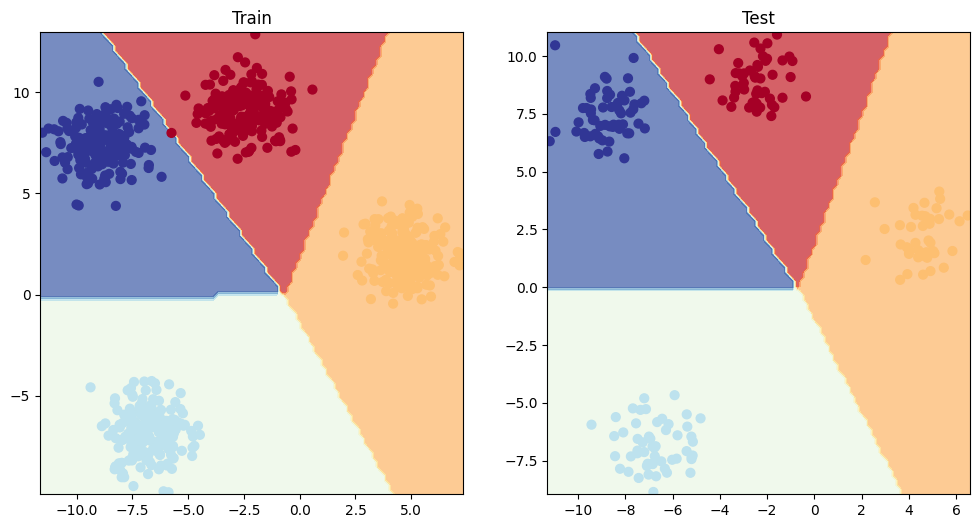

In [175]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_blob_test,y_blob_test)